In [140]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [141]:


file_path1 = 'data/HKQuantityTypeIdentifierSwimmingStrokeCount.csv'
file_path2 = 'data/HKQuantityTypeIdentifierDistanceSwimming.csv'
file_path3 = 'data/HKQuantityTypeIdentifierActiveEnergyBurned.csv'
file_path4 = 'data/HKQuantityTypeIdentifierDistanceCycling.csv'
file_path5 = 'data/HKQuantityTypeIdentifierDistanceWalkingRunning.csv'
file_path6 = 'data/HKQuantityTypeIdentifierHeartRate.csv'
file_path7 = 'data/HKQuantityTypeIdentifierStepCount.csv'


# df1 = pd.read_csv(file_path1, delimiter=';', skiprows=1, on_bad_lines='skip')
# df2 = pd.read_csv(file_path2, delimiter=';', skiprows=1, on_bad_lines='skip')
# df3 = pd.read_csv(file_path3, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
# df4 = pd.read_csv(file_path4, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
# df5 = pd.read_csv(file_path5, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
# df6 = pd.read_csv(file_path6, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
# df7 = pd.read_csv(file_path7, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)


# df1.columns = [col.strip() for col in df1.columns]
# df2.columns = [col.strip() for col in df2.columns]
# df3.columns = [col.strip() for col in df3.columns]
# df4.columns = [col.strip() for col in df4.columns]
# df5.columns = [col.strip() for col in df5.columns]
# df6.columns = [col.strip() for col in df6.columns]
# df7.columns = [col.strip() for col in df7.columns]

# df1['startdate'] = pd.to_datetime(df1['startdate'])
# df1['enddate'] = pd.to_datetime(df1['enddate'])
# df2['startdate'] = pd.to_datetime(df2['startdate'])
# df2['enddate'] = pd.to_datetime(df2['enddate'])
# df3['startdate'] = pd.to_datetime(df3['startdate'])
# df3['enddate'] = pd.to_datetime(df3['enddate'])
# df4['startdate'] = pd.to_datetime(df4['startdate'])
# df4['enddate'] = pd.to_datetime(df4['enddate'])
# df5['startdate'] = pd.to_datetime(df5['startdate'])
# df5['enddate'] = pd.to_datetime(df5['enddate'])
# df6['startdate'] = pd.to_datetime(df6['startdate'])
# df6['enddate'] = pd.to_datetime(df6['enddate'])
# df7['startdate'] = pd.to_datetime(df7['startdate'])
# df7['enddate'] = pd.to_datetime(df7['enddate'])


# df1 = df1[['startdate', 'enddate', 'value']]
# df2 = df2[['startdate', 'enddate', 'value']]
# df3 = df3[['startdate', 'enddate', 'value']]
# df4 = df4[['startdate', 'enddate', 'value']]
# df5 = df5[['startdate', 'enddate', 'value']]
# df6 = df6[['startdate', 'enddate', 'value']]
# df7 = df7[['startdate', 'enddate', 'value']]




# merged_df = pd.merge(df1, df2, on=['startdate', 'enddate'],how='outer', suffixes=('_stroke', '_distancestroke'))
# merged_df = pd.merge(merged_df, df3, on=['startdate', 'enddate'],how='outer', suffixes=('', '_energy'))
# merged_df = pd.merge(merged_df, df4, on=['startdate', 'enddate'],how='outer', suffixes=('', '_distancecycling'))
# merged_df = pd.merge(merged_df, df5, on=['startdate', 'enddate'],how='outer', suffixes=('', '_distancewalkrun'))
# merged_df = pd.merge(merged_df, df6, on=['startdate', 'enddate'],how='outer', suffixes=('', '_heartrate'))
# merged_df = pd.merge(merged_df, df7, on=['startdate', 'enddate'],how='outer', suffixes=('', '_steps'))


# output_path = 'merged_file.csv'
# merged_df.to_csv(output_path, index=False)

# output_path







In [142]:
file_path = 'integrated_workout_data.csv'
df = pd.read_csv(file_path, delimiter=',', skiprows=0, on_bad_lines='skip',low_memory=False)
df = df[['Timestamp', 'Activity', 'Speed']]
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.round('10s')

df3 = pd.read_csv(file_path3, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
df.columns = [col.strip() for col in df.columns]
df3.columns = [col.strip() for col in df3.columns]
df3['startdate'] = pd.to_datetime(df3['startdate'])
df3['enddate'] = pd.to_datetime(df3['enddate'])
df3['Timestamp'] = df3['startdate']
df3['Timestamp'] = pd.to_datetime(df3['Timestamp']).dt.round('10s')
df3 = df3[['Timestamp', 'value']]

merged_df_test = pd.merge(df, df3, on=['Timestamp'],how='left', suffixes=('', '_energy'))

numeric_columns = merged_df_test.select_dtypes(include='number').columns

# Group by the new 'timestamp' and calculate the mean for numeric columns
resampled_df_test = merged_df_test.groupby('Timestamp')[numeric_columns].mean().reset_index()



In [143]:
resampled_df_test.head()

,Timestamp,Speed,value
0,2021-10-19 06:05:00+00:00,0.008777,11.118
1,2021-10-19 06:05:20+00:00,0.307576,NaN
2,2021-10-19 06:05:30+00:00,0.261041,NaN
3,2021-10-19 06:05:40+00:00,0.535457,NaN
4,2021-10-19 06:05:50+00:00,0.364345,NaN


In [144]:
df6 = pd.read_csv(file_path6, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
df6.columns = [col.strip() for col in df6.columns]
df6['startdate'] = pd.to_datetime(df6['startdate'])
df6['enddate'] = pd.to_datetime(df6['enddate'])
df6['Timestamp'] = df6['startdate']
df6['Timestamp'] = pd.to_datetime(df6['Timestamp']).dt.round('10s')
df6 = df6[['Timestamp', 'value']]
merged_df_test = pd.merge(resampled_df_test, df6, on=['Timestamp'],how='left', suffixes=('', '_heartbeat'))

numeric_columns = merged_df_test.select_dtypes(include='number').columns

# Group by the new 'timestamp' and calculate the mean for numeric columns
resampled_df_test = merged_df_test.groupby('Timestamp')[numeric_columns].mean().reset_index()

In [145]:
resampled_df_test.head()

,Timestamp,Speed,value,value_heartbeat
0,2021-10-19 06:05:00+00:00,0.008777,11.118,113.292
1,2021-10-19 06:05:20+00:00,0.307576,NaN,NaN
2,2021-10-19 06:05:30+00:00,0.261041,NaN,NaN
3,2021-10-19 06:05:40+00:00,0.535457,NaN,NaN
4,2021-10-19 06:05:50+00:00,0.364345,NaN,NaN


In [146]:
df4 = pd.read_csv(file_path4, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
df4.columns = [col.strip() for col in df4.columns]
df4['startdate'] = pd.to_datetime(df4['startdate'])
df4['enddate'] = pd.to_datetime(df4['enddate'])
df4['Timestamp'] = df4['startdate']
df4['Timestamp'] = pd.to_datetime(df4['Timestamp']).dt.round('10s')
df4 = df4[['Timestamp', 'value']]

merged_df_test = pd.merge(resampled_df_test, df4, on=['Timestamp'],how='left', suffixes=('', '_distancecycling'))

numeric_columns = merged_df_test.select_dtypes(include='number').columns

# Group by the new 'timestamp' and calculate the mean for numeric columns
resampled_df_test = merged_df_test.groupby('Timestamp')[numeric_columns].mean().reset_index()

In [147]:
resampled_df_test.head()

,Timestamp,Speed,value,value_heartbeat,value_distancecycling
0,2021-10-19 06:05:00+00:00,0.008777,11.118,113.292,NaN
1,2021-10-19 06:05:20+00:00,0.307576,NaN,NaN,NaN
2,2021-10-19 06:05:30+00:00,0.261041,NaN,NaN,NaN
3,2021-10-19 06:05:40+00:00,0.535457,NaN,NaN,NaN
4,2021-10-19 06:05:50+00:00,0.364345,NaN,NaN,NaN


In [148]:
df5 = pd.read_csv(file_path5, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
df5.columns = [col.strip() for col in df5.columns]
df5['startdate'] = pd.to_datetime(df5['startdate'])
df5['enddate'] = pd.to_datetime(df5['enddate'])
df5['Timestamp'] = df5['startdate']
df5['Timestamp'] = pd.to_datetime(df5['Timestamp']).dt.round('10s')
df5 = df5[['Timestamp', 'value']]

merged_df_test = pd.merge(resampled_df_test, df5, on=['Timestamp'],how='left', suffixes=('', '_distancewalkrun'))

numeric_columns = merged_df_test.select_dtypes(include='number').columns

# Group by the new 'timestamp' and calculate the mean for numeric columns
resampled_df_test = merged_df_test.groupby('Timestamp')[numeric_columns].mean().reset_index()

In [149]:
resampled_df_test.head()

,Timestamp,Speed,value,value_heartbeat,value_distancecycling,value_distancewalkrun
0,2021-10-19 06:05:00+00:00,0.008777,11.118,113.292,NaN,NaN
1,2021-10-19 06:05:20+00:00,0.307576,NaN,NaN,NaN,NaN
2,2021-10-19 06:05:30+00:00,0.261041,NaN,NaN,NaN,NaN
3,2021-10-19 06:05:40+00:00,0.535457,NaN,NaN,NaN,NaN
4,2021-10-19 06:05:50+00:00,0.364345,NaN,NaN,NaN,NaN


In [150]:
df7 = pd.read_csv(file_path7, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
df7.columns = [col.strip() for col in df7.columns]
df7['startdate'] = pd.to_datetime(df7['startdate'])
df7['enddate'] = pd.to_datetime(df7['enddate'])
df7['Timestamp'] = df7['startdate']
df7['Timestamp'] = pd.to_datetime(df7['Timestamp']).dt.round('10s')
df7 = df7[['Timestamp', 'value']]

merged_df_test = pd.merge(resampled_df_test, df7, on=['Timestamp'],how='left', suffixes=('', '_steps'))

numeric_columns = merged_df_test.select_dtypes(include='number').columns

# Group by the new 'timestamp' and calculate the mean for numeric columns
resampled_df_test = merged_df_test.groupby('Timestamp')[numeric_columns].mean().reset_index()

In [151]:
output_path_test = 'merged_file_test.csv'
resampled_df_test.to_csv(output_path_test, index=False)

In [152]:
output_path_df_test = 'df_file_test.csv'
df_test = resampled_df_test.tail(4600)
df_test.to_csv(output_path_df_test, index=False)

In [153]:

df_test['value'].fillna(0, inplace=True)

nan_values_per_column = df_test.isna().sum()

print(nan_values_per_column)

Timestamp                   0
Speed                       0
value                       0
value_heartbeat             3
value_distancecycling    3730
value_distancewalkrun    1336
value_steps              4427
dtype: int64


/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_20209/689802479.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['value'].fillna(0, inplace=True)
/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_20209/689802479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['value'].fillna(0, inplace=True)


In [154]:



df = df_test

train_df = df[df['value'] != 0]
test_df = df[df['value'] == 0]


X_train = train_df['Speed'].values.reshape(-1, 1)
y_train = train_df['value'].values.reshape(-1, 1)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = 1
model = SimpleNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_model(model, train_loader, criterion, optimizer, epochs=25):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train_model(model, train_loader, criterion, optimizer, epochs=25)

X_test = test_df['Speed'].values.reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
model.eval()
with torch.no_grad():
    predicted_values = model(X_test_tensor).numpy()

df.loc[df['value'] == 0, 'value'] = predicted_values.flatten()
output_file_path = 'df_value_predicted.csv'
df.to_csv(output_file_path, index=False)

Epoch [1/25], Loss: 0.0186
Epoch [2/25], Loss: 0.0084
Epoch [3/25], Loss: 0.0103
Epoch [4/25], Loss: 0.0002
Epoch [5/25], Loss: 0.0074
Epoch [6/25], Loss: 0.0010
Epoch [7/25], Loss: 0.0004
Epoch [8/25], Loss: 0.0225
Epoch [9/25], Loss: 0.0089
Epoch [10/25], Loss: 0.0056
Epoch [11/25], Loss: 0.0118
Epoch [12/25], Loss: 0.0114
Epoch [13/25], Loss: 0.0008
Epoch [14/25], Loss: 0.0014
Epoch [15/25], Loss: 0.0010
Epoch [16/25], Loss: 0.0019
Epoch [17/25], Loss: 0.0026
Epoch [18/25], Loss: 0.0028
Epoch [19/25], Loss: 0.0041
Epoch [20/25], Loss: 0.0018
Epoch [21/25], Loss: 0.0018
Epoch [22/25], Loss: 0.0011
Epoch [23/25], Loss: 0.0014
Epoch [24/25], Loss: 0.0013
Epoch [25/25], Loss: 0.0052


In [155]:
file_path = 'df_value_predicted.csv'
df = pd.read_csv(file_path, parse_dates=['Timestamp'])
df.sort_values('Timestamp', inplace=True)

def fill_nan_heartbeat(df):
    for i in range(len(df)):
        if pd.isna(df.loc[i, 'value_heartbeat']):
            start_idx = max(i - 2, 0)
            end_idx = min(i + 3, len(df))
            surrounding_values = df.loc[start_idx:end_idx, 'value_heartbeat']
            mean_value = surrounding_values.mean()
            df.loc[i, 'value_heartbeat'] = mean_value
    return df

df = fill_nan_heartbeat(df)
output_file_path = 'df_heartbeat_filled.csv'
df.to_csv(output_file_path, index=False)
print(df.head())


                  Timestamp     Speed     value  value_heartbeat  \
0 2024-02-05 14:54:30+00:00  1.640148  0.322667       123.500000   
1 2024-02-05 14:54:40+00:00  1.712500  0.339000       123.666667   
2 2024-02-05 14:54:50+00:00  1.634478  0.396750       124.000000   
3 2024-02-05 14:55:00+00:00  1.324659  0.377000       124.666667   
4 2024-02-05 14:55:10+00:00  1.459364  0.310500       124.000000   

   value_distancecycling  value_distancewalkrun  value_steps  
0                    NaN               0.004820        884.0  
1                    NaN               0.004316          NaN  
2                    NaN               0.004186          NaN  
3                    NaN               0.002988          NaN  
4                    NaN               0.004114          NaN  


In [156]:

nan_values_per_column = df.isna().sum()

print(nan_values_per_column)

Timestamp                   0
Speed                       0
value                       0
value_heartbeat             0
value_distancecycling    3730
value_distancewalkrun    1336
value_steps              4427
dtype: int64


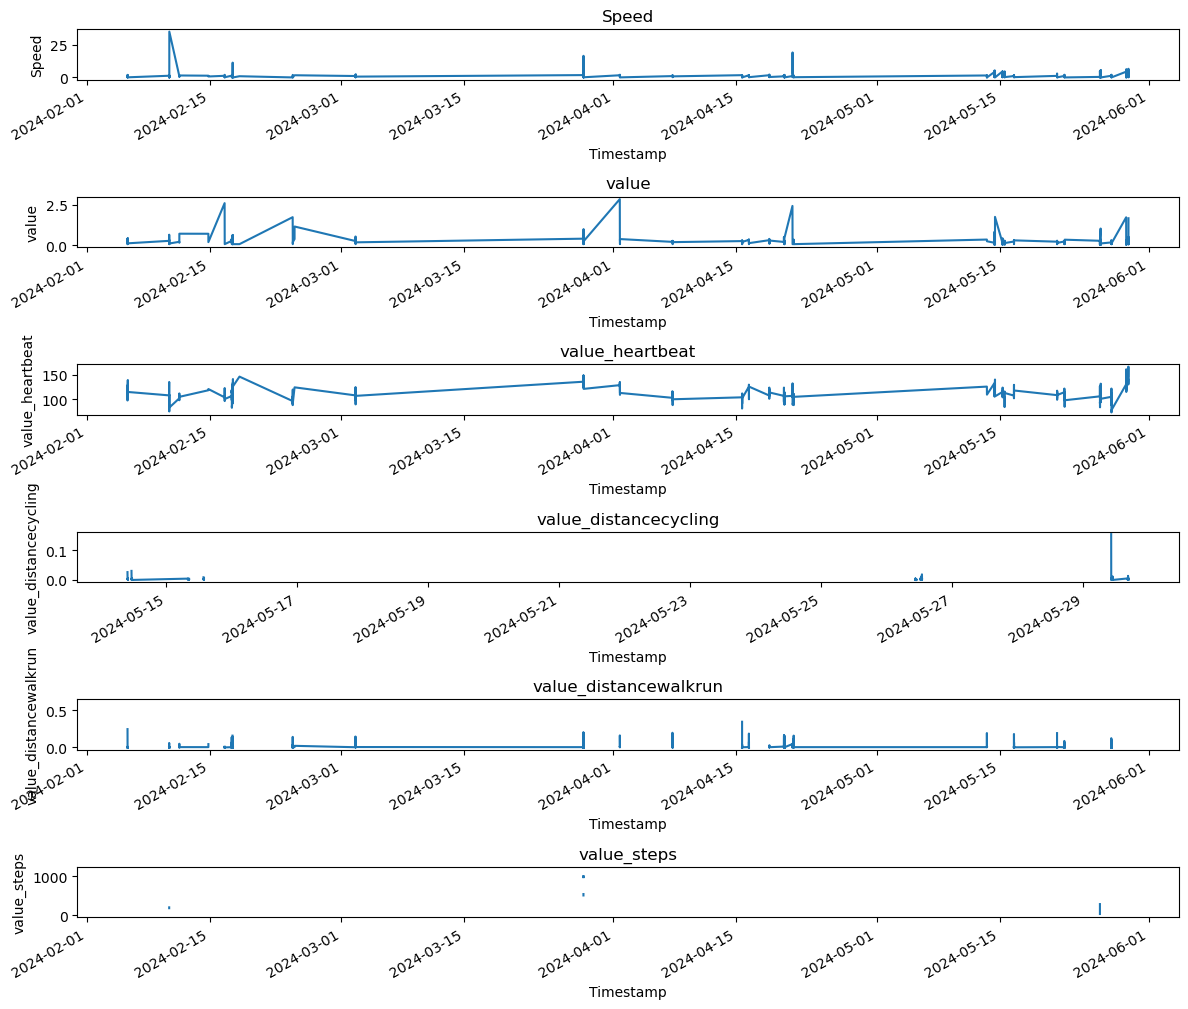

In [157]:
import matplotlib.pyplot as plt

file_path = 'df_heartbeat_filled.csv'
df = pd.read_csv(file_path, parse_dates=['Timestamp'])
# Convert the Timestamp column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set Timestamp as the index
df.set_index('Timestamp', inplace=True)

# Define the number of subplots based on the number of columns (excluding the index)
num_plots = df.shape[1]

# Create subplots
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 1.7 * num_plots))

# Plot each column in a separate subplot
for i, column in enumerate(df.columns):
    df[column].plot(ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('Timestamp')
    axes[i].set_ylabel(column)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


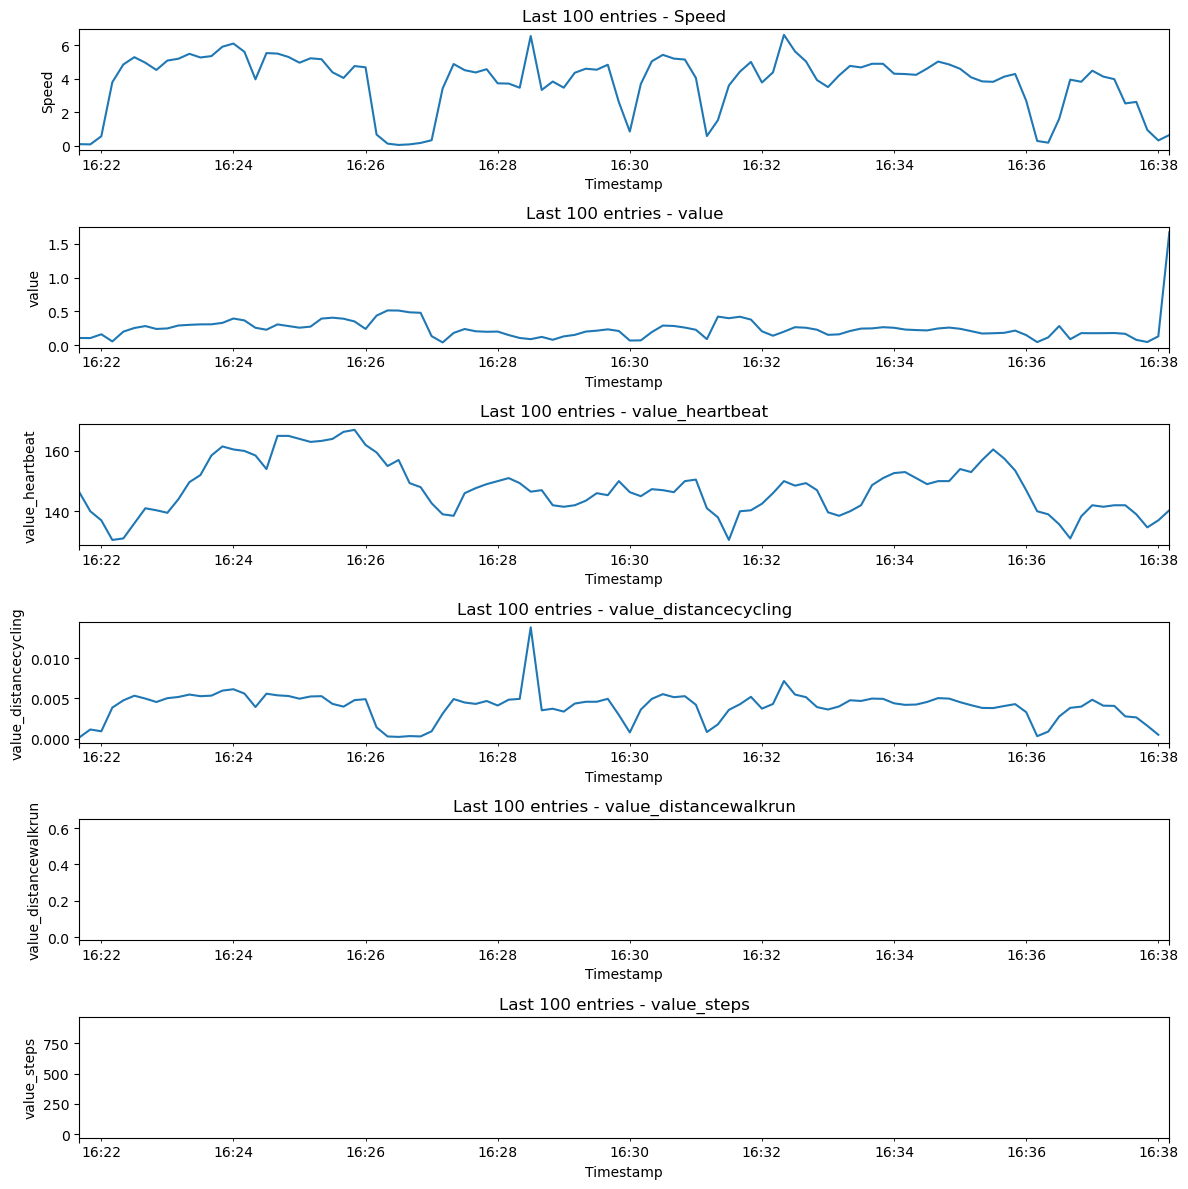

In [158]:
# Plot the last 100 entries of the dataframe
df_last_100 = df.tail(100)

# Create subplots for the last 100 entries
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 2 * num_plots))

# Plot each column in a separate subplot for the last 100 entries
for i, column in enumerate(df_last_100.columns):
    df_last_100[column].plot(ax=axes[i])
    axes[i].set_title(f'Last 100 entries - {column}')
    axes[i].set_xlabel('Timestamp')
    axes[i].set_ylabel(column)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


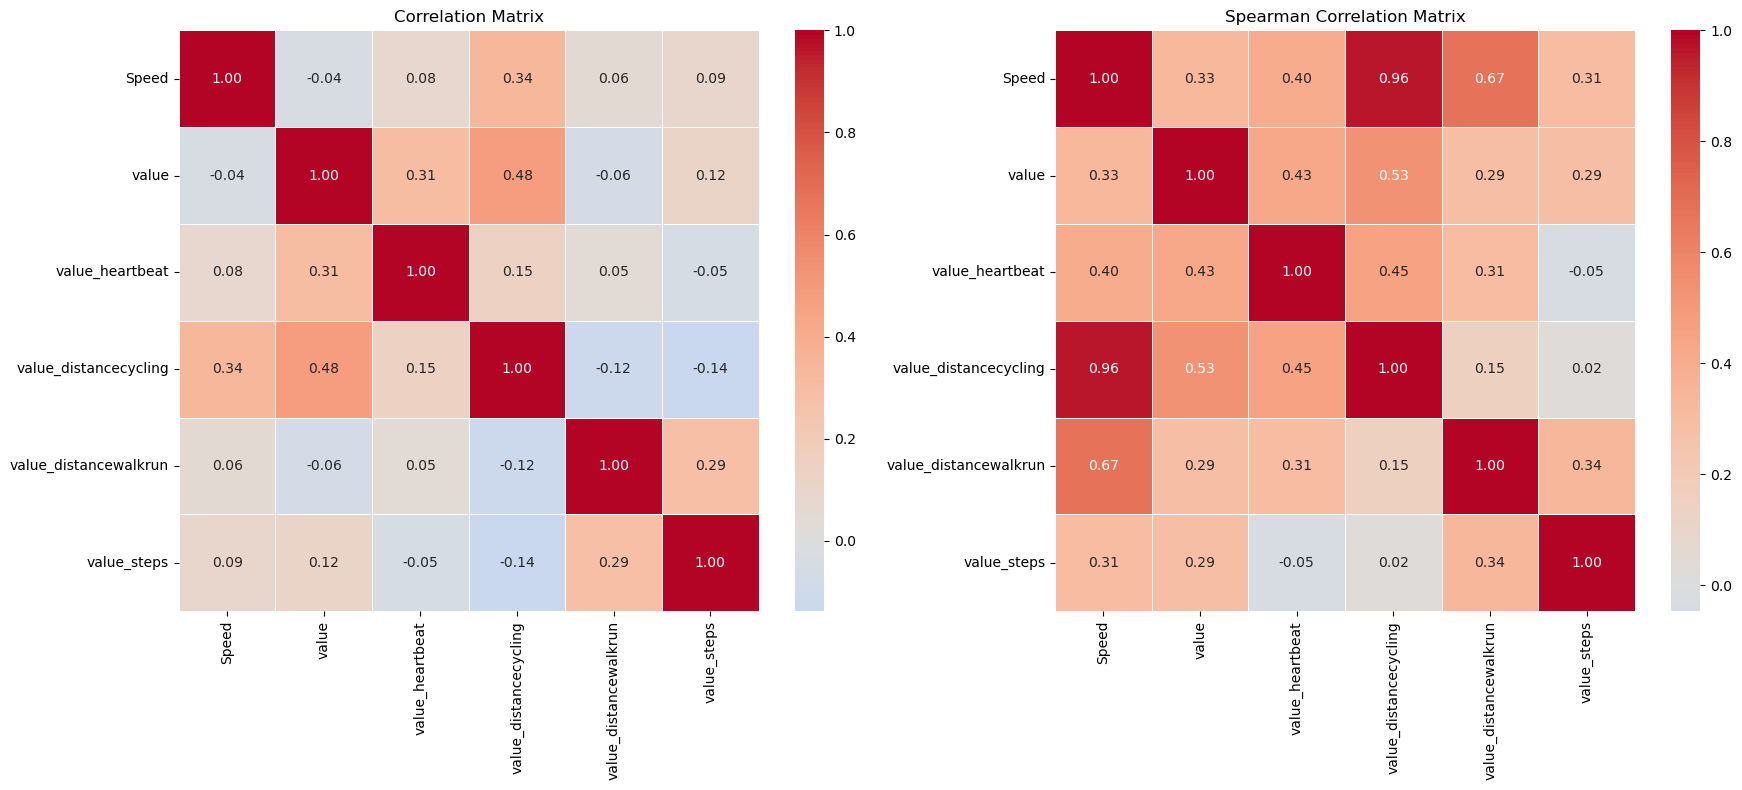

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = 'df_heartbeat_filled.csv'
df = pd.read_csv(file_path)

# Exclude non-numeric columns for correlation calculation
df_numeric = df.select_dtypes(include='number')

# Calculate correlation matrices
correlation_matrix = df_numeric.corr()
spearman_corr = df_numeric.corr(method='spearman')

# Plotting Pearson and Spearman correlation matrices side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Pearson Correlation Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f", ax=axes[0])
axes[0].set_title('Correlation Matrix')

# Spearman Correlation Heatmap
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f", ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix')

plt.tight_layout()
plt.show()


In [162]:
df_dropped = df.iloc[:, :-3]
df_dropped.head()
output_file_path = 'df_only_filled_values.csv'
df_dropped.to_csv(output_file_path, index=False)